In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Do We Have Different Whatsapp Styles?

Spurred on by the findings of the Laugh Word Containing piece, I've decided to investigate all of our messages more generally. The odd comment is made here or there about a delayed response from Fred, my scattergun message style or JB always being available for 'banter'. But how true are these statements? And if I did my best, could I predict whose message is it based on a limited subset of variables?

__In other words, are we all boring blokes with the same jokes, same words, but even more - the same statistical properties of our message conciousness?__

The aim here is to:
 - look into it a bit, tease out some general trends or characteristics
 - assess whether there is 'variance' in that characteristic between us ('Authors')
 - assess whether we can use that variation to make a classification algorithm with a high degree of accuracy (correct predictions) about who sent a message based on _fairly_ limited metadata about the message

First we whip the data back into mem and ensure it's how we left it:

In [1]:
# import the heavy lifters
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# bring in them stats libs
from scipy import stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

# suppress them pesky warnings
import warnings
warnings.filterwarnings('ignore')

# set some tabular and graphical formatting
sns.set()
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [2]:
# import the data and ensure datetime cols parsed appropriately 
df = pd.read_csv('./data/wa_df.csv', parse_dates=['Date', 'DateTime', 'Month', 'Time'])
df['Time'] = df['Time'].dt.time
# change 'You Changed' author to moi
df['Author'] = np.where(df['Author'] == 'You changed', 'Mark Jamison',  df['Author'])
df.tail()

,Date,Time,Author,Message,Group,DateTime,Hour,Month,ContainsHahaWord,HahaLaughWord,ContainsLolWord,LolLaughWord,ContainsLaughWord,ContainsBothLaughWord,OnlyHahaWord,OnlyLolWord,OnlyLaughWord,LaughWord
15392,2021-02-23,08:32:40,Edward Maclachlan,Dom put the house account details down so roop...,vow,2021-02-23 08:32:40,8,2021-02-01,False,None,False,None,False,False,False,False,False,None
15393,2021-02-23,08:33:02,Don Batten,same acct you used to pay rent into roop,vow,2021-02-23 08:33:02,8,2021-02-01,False,None,False,None,False,False,False,False,False,None
15394,2021-02-23,08:33:05,Don Batten,many moons ago,vow,2021-02-23 08:33:05,8,2021-02-01,False,None,False,None,False,False,False,False,False,None
15395,2021-02-23,08:33:20,Rupert Hill,Yer nice,vow,2021-02-23 08:33:20,8,2021-02-01,False,None,False,None,False,False,False,False,False,None
15396,2021-02-23,08:37:29,Joe Bourne,Don’t embezzle,vow,2021-02-23 08:37:29,8,2021-02-01,False,None,False,None,False,False,False,False,False,None


Given we exported content-stripped Whatsapp data (image replaced by 'image omitted') we need to handle this to prevent:
 - skewing content stats i.e. only counting http links
 - skewing word lengths by content messages counting as 2 word messages

In [3]:
# create col to keep track of visual shared
# prefer one str based col to a boolean col (ContainsContent)
# and then another str col describing content (image, video etc)
print('Handling {:,} messages with hawt viz content'.format(df['Message'].str.contains('omitted').sum()))
df['ContainsViz'] = np.where(df['Message'].str.contains('omitted'), df['Message'].str.replace(' omitted', ''), 'None')
# now update these messages to be textless
df['Message'] = np.where(df['Message'].str.contains('omitted'), '', df['Message'])

Handling 1,501 messages with hawt viz content


## 1. Message Length

Who's the most monosyllabic among us? Who is prone to a political spiel? Or is it all much of a muchness? First up, let's compare our message lengths.

In [4]:
df['WordCount'] = df['Message'].str.split(' ').str.len()

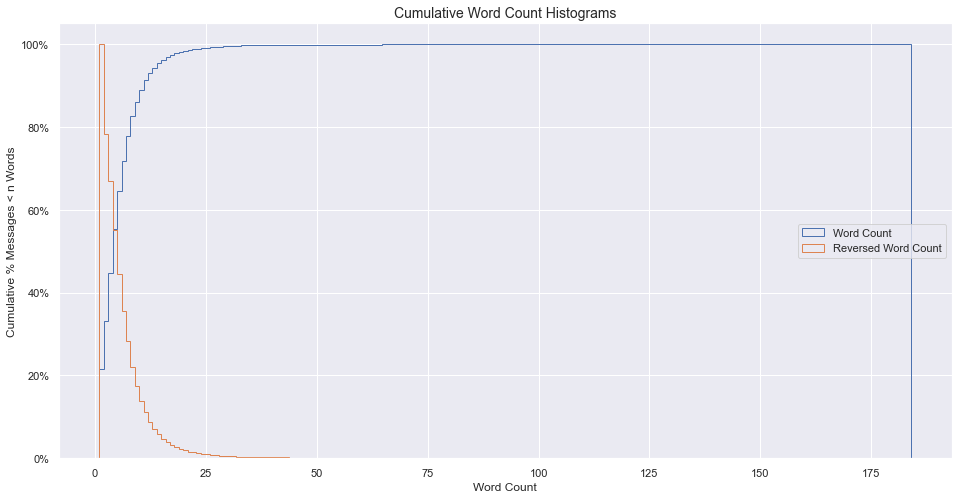

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))

# plot the cumulative histogram
ax.hist(df[df.ContainsViz == 'None']['WordCount'], max(df['WordCount']), density=True,
        histtype='step', cumulative=True, label='Word Count')

# overlay a reversed cumulative histogram
ax.hist(df[df.ContainsViz == 'None']['WordCount'], max(df['WordCount']), density=True,
        histtype='step', cumulative=-1, label='Reversed Word Count')

# tidy up the figure
ax.legend(loc='right')
ax.set_title('Cumulative Word Count Histograms', fontdict={'fontsize': 14})
ax.set_xlabel('Word Count')
ax.set_ylabel('Cumulative % Messages < n Words')
ax.set_yticklabels(['{:,}'.format(int(x*100))+'%' for x in ax.get_yticks().tolist()]);

So it looks like no one is writting essays:
 - We are blokes of few words - messages tend to be short with a few 'tail events' (possibly shared content)
 - Almost 100% of messages fall in the sub 25 word space with it looking like >80% falling sub 10 words
 
From inspection, the longer messages are all one of the following:
 - Airbnb descriptions
 - Email drafts to be sent to your beloved landlord
 - Fred's bizarre dreams
 - Horrifically boring admin (RIP Swiss SALT 4G booster etc.)
 
We can bin the tail (as in let's chuck it, not group it) and work with the sub 25 word count region.

In [6]:
# only sub 25 word messages PLEASE
word_limit = 25
df = df[df.WordCount <= word_limit]

But how does this message length compare per person? Let's get the violins out!!!!

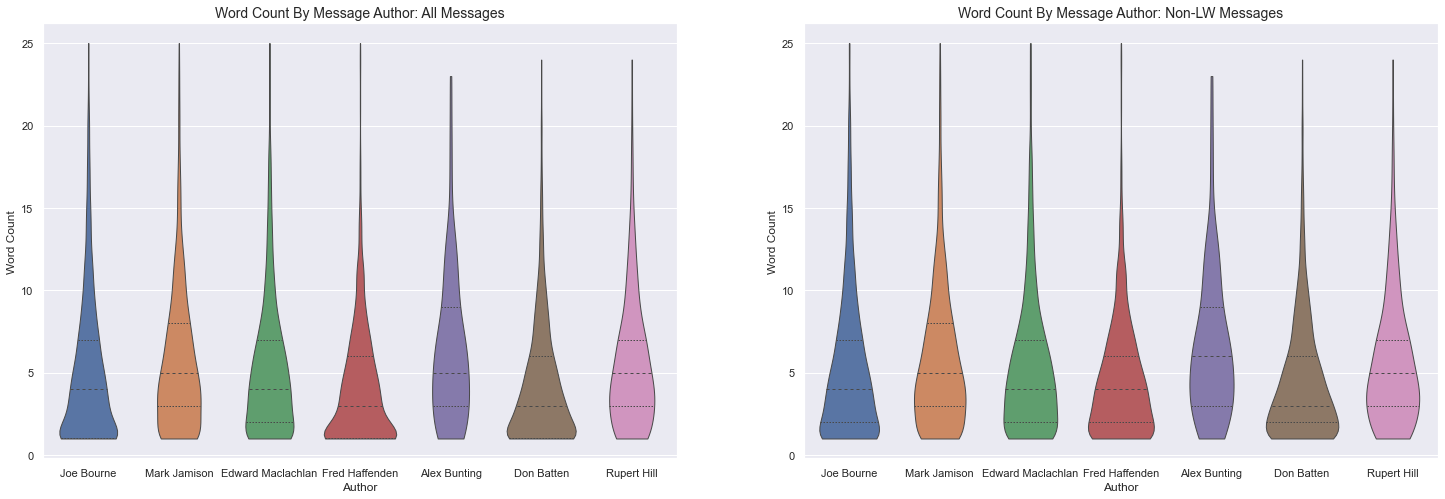

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))

# violin for all messages
sns.violinplot(data=df[df.ContainsViz == 'None'], x="Author", y="WordCount", ax=ax[0], cut = 0,
               split=True, inner="quart", linewidth=1);
ax[0].set_title('Word Count By Message Author: All Messages', fontdict={'fontsize': 14})
ax[0].set_xlabel('Author')
ax[0].set_ylabel('Word Count')

# non laugh word only messages
sns.violinplot(data=df[(df.ContainsViz == 'None') & ~df.OnlyLaughWord], x="Author", y="WordCount", ax=ax[1], cut = 0,
               split=True, inner="quart", linewidth=1);
ax[1].set_title('Word Count By Message Author: Non-LW Messages', fontdict={'fontsize': 14})
ax[1].set_xlabel('Author')
ax[1].set_ylabel('Word Count');

So what does this show?
 - Dumpy violins represent a high density of short messages - Fred is particularly monosyllabic, but the chart on the right shows this can partially be attributed to single word laughter responses e.g. 'haha' in response to something no doubt off-the-chain hilarious
 - The group appears split in two:
   - {Myself, Ed, Rup, Al}: higher density of longer messages
   - {Joe, Fred, Dom}: The monosyllabic grunters

### 1a. Do We Have Different Message Lengths _Statistically Speaking_?

So we can eyeball the above violins and group _or_ we can pretend to be super smart and use [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) to determine if the mean message length from each of us is 'statistically different'.

#### 1ai. Explaining the Basic t-Test

What is a standard 'Students t-test'? Given a sample of data from a 'true' underlying data generating process we can compute a 'test statistic':
$$t = \frac{\bar{x} - \mu}{\hat{\sigma} / \sqrt{n}}$$
where:
 - $\bar{x}$ is the average of our sample e.g. the average height of people in the sample
 - $\mu$ is the 'true' average e.g. if we took **everyone ever ever** and measured the average
 - $\hat{\sigma}$ is the sample std deviation
 - $n$ is the number of observations in the sample e.g. number of people we sample for their height

Now, _if_ the above 'true' data generating process is normally distributed, then the above 'statistic' (so called because it is 'random' as it will change depending on which sample we choose) will have a certain distribution. This is a [Student t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).

If $\bar{x} = \mu$, then we would assume $t = 0$ - we can then look up the distribution and see for a given $n$ how likely this would be to occur by chance.

Let's prove that quickly:
 - we can generate 1,000 t stats where each t stat is computed by sampling 100 numbers from a normal distribution
 - we can then plot the histogram of those t-stats and compare to the best fit t distribution that python.scipy spits out for us

In [8]:
# generate 1000 t stats by generating samples from a normal distribution
t_stats = []
true_mean = 10
true_std_dev = 2
for i in range(1, 1001):
    # generate random sample of 100 numbers from norm dist, mean=10, std_dev=2
    norm_smpls = np.random.normal(loc=true_mean, scale=true_std_dev, size=100)
    # compute sample mean and std_dev --> in limit this will approach 10 and 2
    x_bar = norm_smpls.mean()
    std_dev = norm_smpls.std()
    # compute t-stat for this sample
    t_stat = (x_bar - true_mean) /(std_dev / 100**0.5)
    t_stats.append(t_stat)

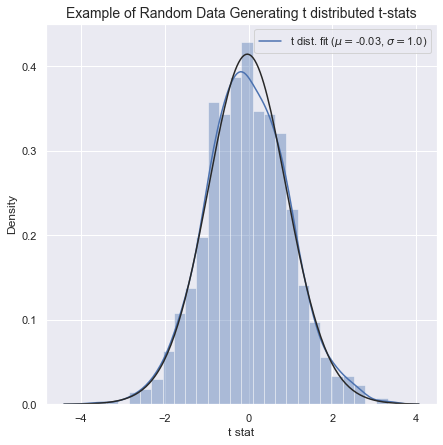

In [9]:
# plot histo
fig, ax = plt.subplots(figsize=(7,7))
sns.distplot(t_stats, fit=stats.t, ax=ax)
# spit out params from t to compare to 'actual' params used to plot
(rando_num, mu, sigma) = stats.t.fit(t_stats)
ax.legend(["t dist. fit ($\mu=${0:.2f}, $\sigma=${1:.1f})".format(mu, sigma)])
plt.title('Example of Random Data Generating t distributed t-stats', fontdict={'fontsize':14})
plt.xlabel('t stat');

So as the chart shows, the distirbution of our computed t-stat looks good with scipy.stats computing a best fit distribution with $\mu = 0$ and $\sigma = 1$

### 1aii. The Welch t-Test

The above works well if we want to compare something to a fixed number (e.g. is the mean equal to 2). But what if we want to compare 2 statistics for their equality?

Your boiii Bernard Welch and his t-test allows us to do this:
 - because given a large sample, the _sample mean_ will be normally distributed *even if the data itself is not* (will prove) - [explained here](https://stats.stackexchange.com/questions/9573/t-test-for-non-normal-when-n50)
 - we can normalise for the data having unknown and different variances

First let's show that by:
 - Sample many times from my messages to get a sample of messages (and their word counts - the variable we are interested in)
 - compute the mean
 - the distribution of that mean *should be* normally distributed

hence we can use Welch's test - although _technically_ we could use the [Wilcoxon non-parametric test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) in the age of being unbounded by processing power.

In [10]:
mean_samp = []
# generate 200 samples from all my messages, compute mean, add to list of means
for x in range(1, 200):
    df_samp = df[(df.Author == 'Mark Jamison') & (df.ContainsViz == 'None')].sample(100)
    m_pc = df_samp['WordCount'].mean()
    mean_samp.append(m_pc)

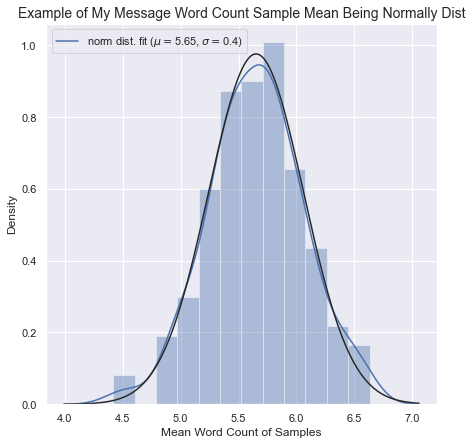

In [11]:
# plot histo
fig, ax = plt.subplots(figsize=(7,7))
sns.distplot(mean_samp, fit=stats.norm, ax=ax)
# spit out params from norm to compare to 'actual' params used to plot
(mu, sigma) = stats.norm.fit(mean_samp)
ax.legend(["norm dist. fit ($\mu=${:.2f}, $\sigma=${:.1f})".format(mu, sigma)])
plt.title('Example of My Message Word Count Sample Mean Being Normally Dist', fontdict={'fontsize':14})
plt.xlabel('Mean Word Count of Samples');

### 1b. Computing the Welch Test Statistics

So hopefully this examples what we're doing and why we can do it - now we can just dive in and do the following:
 - Compute the stats for each of us - the authors
 - Compute the t-stats for each of us to spit out a matrix of t-stats that we can use to decide whether or not we have statistically different message lengths

In [12]:
authors = df.Author.unique()
authors.sort()
author_pairs = list(itertools.combinations(authors, 2))
print('We have {} pairs of authors to compare their message word count distribution means'.format(len(author_pairs)))

We have 21 pairs of authors to compare their message word count distribution means


In [13]:
t_test_output = []
# for each pair
for pair in author_pairs:
    # get our word count distributions
    author_1_wc = df[(df.Author == pair[0]) & (df.ContainsViz == 'None')]['WordCount'].values
    author_2_wc = df[(df.Author == pair[1]) & (df.ContainsViz == 'None')]['WordCount'].values
    # compute t stat and append to list
    t_test = stats.ttest_ind(author_1_wc, author_2_wc, equal_var=False)
    t_test_output.append([pair[0], pair[1], abs(t_test[0]), t_test[1]])

In [14]:
# stick in df and make 2 piv'ed dfs of t-stats and p values
df_mess_len_stats = pd.DataFrame(t_test_output, columns=['Author1', 'Author2', 't_stat', 'p_value'])
df_mess_len_t = pd.pivot_table(df_mess_len_stats, columns='Author1', index='Author2', values='t_stat')
df_mess_len_p = pd.pivot_table(df_mess_len_stats, columns='Author1', index='Author2', values='p_value')

Now we've computed them we can spit them out nicely so we can have a look at the results (giddy!!!!)

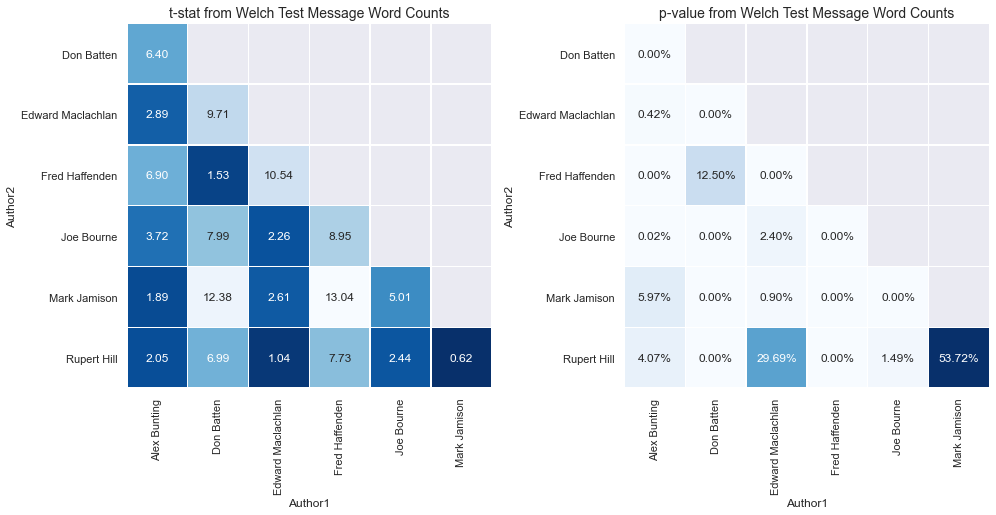

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

sns.heatmap(df_mess_len_t, ax=ax[0], square=True, linewidths=.5, cmap='Blues_r', cbar=False, annot=True, fmt='.2f')
ax[0].set_title('t-stat from Welch Test Message Word Counts', fontdict={'fontsize': 14})
sns.heatmap(df_mess_len_p, ax=ax[1], square=True, linewidths=.5, cmap='Blues', cbar=False, annot=True, fmt='.2%')
ax[1].set_title('p-value from Welch Test Message Word Counts', fontdict={'fontsize': 14})

fig.tight_layout();

So the initial guess work based on eye-balling the distribution plots was _kind of_ right:
 - the 'hypothesis' that Ed's, Rupert's and my messages have equal average word length cannot be rejected (low teeess, high peeesss)
   - e.g. rupert vs ed, under the null hypothesis that they have equal average message word counts
   - the probability of obtaining the sample outcome we have (the avg word counts from the sample of messages) by chance is 29.69% (so a bit high to say that they have different word counts)
 - everyone else has statistically significant different average word counts

__So, in short, for the most part message length alone is a useful metric to have a guess at who's messaging - longer messages more likely myself, Ed or Rupert; shorter more likely JB, Don or Fred. But probably Fred.__

## 2. Rapid Fire vs Ramble

There seem to be infinite forums discussing the relative merits of the one longer message vs machine gun bursts ([here](https://www.reddit.com/r/socialskills/comments/2n3u06/is_it_better_to_send_one_long_text_or_several/), [here](https://www.quora.com/Why-do-guys-not-all-send-multiple-text-messages-in-a-row-instead-of-fitting-the-entire-message-in-one-message),[here](https://www.quora.com/Why-do-people-dislike-it-when-someone-messages-them-with-a-bunch-of-separate-texts-instead-on-one-long-text-With-multiple-texts-you-can-read-while-waiting-for-the-other-persons-next-message) and even [here](https://stackoverflow.com/questions/9651570/whats-faster-sending-multiple-small-messages-or-less-longer-messages-with-tcp-so)). I personally love the rapid fire as a method of typing (usually meaningless) streams of conciousness, __but is there a discernable difference in the group between the rapid firers and the ramblers?__

Sorting our messages by {Whatsapp group, DateTime}, we can then find 'self replies' - for now we'll leave it open as to whether this is mid-burst or responding to your own lead balloon.

In [16]:
# add new col for who sent the prev message
df = df.sort_values(['Group','DateTime'])
df['PrevAuthor'] = df.groupby('Group')['Author'].shift()
# boolean for replying to yourself
df['SelfReply'] = df.Author == df.PrevAuthor

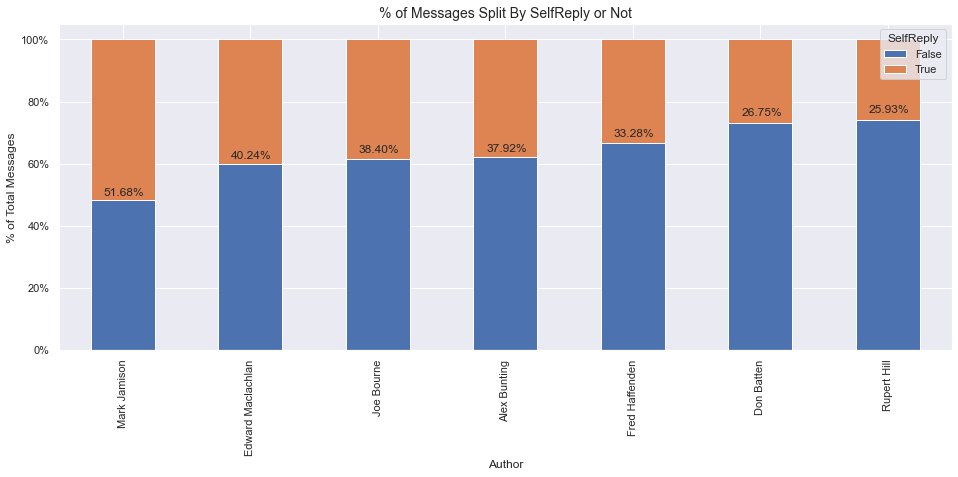

In [17]:
fig, ax = plt.subplots(figsize=(16,6))

# one liner because i'm lazy and my mac appears to be struggling
pd.pivot_table(df[['SelfReply', 'Author', 'Message']]
               .groupby(['Author','SelfReply']).count() /
               df[['Author', 'Message']]
               .groupby(['Author']).count(),
               columns='SelfReply',
               index='Author',
               values='Message').sort_values(True, ascending=False).plot(kind='bar', stacked=True, ax=ax)
plt.title('% of Messages Split By SelfReply or Not', fontdict={'fontsize':14})
plt.xlabel('Author')
plt.ylabel('% of Total Messages')
ax.set_yticklabels(['{:,}'.format(int(x*100))+'%' for x in ax.get_yticks().tolist()]);

# instead of printin df beside, can just add % labels by stripping bar size from mpl 'get_height'
width_adj = 0
for p in ax.patches[:int(len(ax.patches)/2)]:
    if ax.patches.index(p) == 0:
        width_adj = p.get_x() * -0.4
    ax.annotate('{:.2f}'.format(100*(1 - p.get_height()))+'%', (p.get_x() + width_adj, p.get_height() * 1.03))

So it appears:
 - that I am indeed a keen rapid firer
 - on the contrary Rupert & Dom are one-n-done kinda guys - get in there with what they have to say (well thought through no doubt), then fall back
 - Ed, Joe, Al, Fred are more in the middle with around 35-40% self-reply rate

Similar to above with message length, can we use this info to _statistically speaking_ say that we have differing self-reply rates and so this could indeed be a good discriminator if used to help predict who sent what message?

### 2a. Do We Have Differing Self Reply Rates?

Given that:
 - we have a sample of messages that have a binary response (self reply or not)
 - we use that binary response to calc a proportion

we can use a [z-test](https://en.wikipedia.org/wiki/Z-test) as under the null hypothesis (of equal proportions of self replies) we will have a normally distributed test statistic. But first we need to construct that test statistic.

#### 2ai. Constructing Test Statistic for Equal Variances

There appears to be [_raging debate_](https://stats.stackexchange.com/questions/225950/two-sample-hypothesis-test-for-difference-between-two-proportions-pooled-vs-unp) in the poppin stats community about the correct stat to use, but given we are under the null, assuming equal proportions, we will compute the 'pooled stat'. So our test statistic is the following:
$$z = \frac{\bar{x_1} - \bar{x_2}}{\sigma_{1-2} / \sqrt{n_{1+2}}}$$
where:
 - $\bar{x_i}$ is the sample mean (i.e. self reply rate as this is the mean of the binary variable of self reply or not)
 - $\sigma_{1-2}$ is the variance of the differences of these 2 things _from the population of all possible messages ever_

We don't know $\sigma_{1-2}$, but under the null of equal reply rates, we can assume that each author's self-reply rate comes from the same dist, with the same variance and so we can _pool_ the variances by estimating the pop variance from the individual sample variances i.e. replace $\sigma_{1-2}$ with $\hat{\sigma}_{1-2}$.

We also know that these variables are binomially distributed and so the variance of each is $n*p*(1-p)$ where p is the rate. This gives us a pooled variance of:

$$
\begin{align}
\sigma_{1-2}^2 &= \sigma_1^2 + \sigma_2^2 \\
&= [n_{1+2} * p_{1+2} * (1 - p_{1+2})] * (\frac{1}{n_1} + \frac{1}{n_2}) \\
\end{align}
$$

where e.g. $n_{1+2}$ means the number of messages summed across both authors and the portion in square brackets is the pooled sample variance.

We can do a quick check that if we take a load of samples of e.g. my messages and Fred's messages that the above z-stat will be normally distributed.

In [18]:
z_stats = []
# generate 200 samples from all my messages and fred's messages, compute z-stat
for x in range(1, 500):
    # get messages
    df_me = df[df.Author == 'Mark Jamison']['SelfReply'].sample(100)
    df_fred = df[df.Author == 'Fred Haffenden']['SelfReply'].sample(100)
    # get props of self replies
    p_me = df_me.mean()
    p_fred = df_fred.mean()
    # get pooled prop, will just be avg as equal sample size
    p_pool = (p_me * len(df_me) + p_fred * len(df_fred)) / (len(df_me) + len(df_fred))
    # get pooled var est
    var_pool = p_pool * (1 - p_pool) * ((1/len(df_me) + 1/len(df_fred)))
    # compute zstat and add to list
    z_stat = (p_me - p_fred) / var_pool**0.5
    z_stats.append(z_stat)

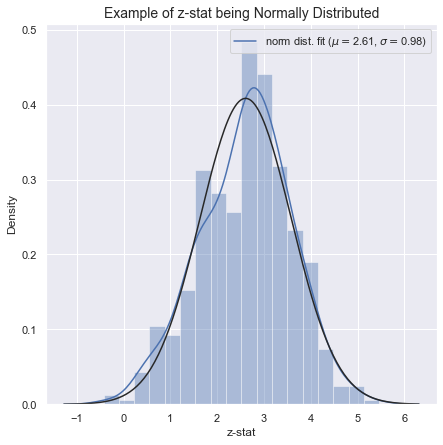

In [19]:
# plot histo
fig, ax = plt.subplots(figsize=(7,7))
sns.distplot(z_stats, fit=stats.norm, ax=ax)
# spit out params from norm to compare to 'actual' params used to plot
(mu, sigma) = stats.norm.fit(z_stats)
ax.legend(["norm dist. fit ($\mu=${:.2f}, $\sigma=${:.2f})".format(mu, sigma)])
plt.title('Example of z-stat being Normally Distributed', fontdict={'fontsize':14})
plt.xlabel('z-stat');

So as expected, the resulting best fit distribution is approx. Normal with var of 1.0 - if Fred and I had similar self reply rates we would see this centered around 0.

#### 2aii. Compute The Tests

Now we're comfortable with what's going on - let's test to see if we have statistically different rates of replying to ourselves i.e. rapid fire vs one-long-message messaging approaches.

In [20]:
z_test_output = []
# for each pair
for pair in author_pairs:
    # get our message totals and self reply counts
    author_1_mess = df[df.Author == pair[0]]
    a1_len = len(author_1_mess)
    a1_srr = author_1_mess['SelfReply'].sum()
    author_2_mess = df[df.Author == pair[1]]
    a2_len = len(author_2_mess)
    a2_srr = author_2_mess['SelfReply'].sum()
    # compute z stat and append to list
    z_test = proportions_ztest([a1_srr, a2_srr], [a1_len, a2_len])
    z_test_output.append([pair[0], pair[1], abs(z_test[0]), z_test[1]])

In [21]:
# stick in df and make 2 piv'ed dfs of t-stats and p values
df_rr_stats = pd.DataFrame(z_test_output, columns=['Author1', 'Author2', 'z_stat', 'p_value'])
df_rr_z = pd.pivot_table(df_rr_stats, columns='Author1', index='Author2', values='z_stat')
df_rr_p = pd.pivot_table(df_rr_stats, columns='Author1', index='Author2', values='p_value')

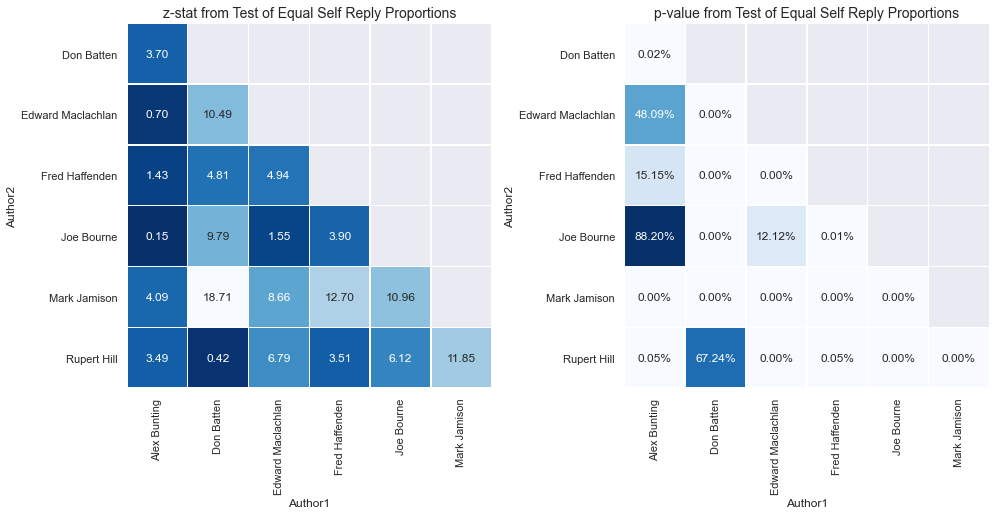

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

sns.heatmap(df_rr_z, ax=ax[0], square=True, linewidths=.5, cmap='Blues_r', cbar=False, annot=True, fmt='.2f')
ax[0].set_title('z-stat from Test of Equal Self Reply Proportions', fontdict={'fontsize': 14})
sns.heatmap(df_rr_p, ax=ax[1], square=True, linewidths=.5, cmap='Blues', cbar=False, annot=True, fmt='.2%')
ax[1].set_title('p-value from Test of Equal Self Reply Proportions', fontdict={'fontsize': 14})

fig.tight_layout();

So:
 - yeah we do - we almost all have statistically different rates of self-replying
 - Ms Al Bunting (although only 240 messages total in DSS so affects rates) has similar style to JB, Fred and her beloved
 - Dom and Rupert, as per the above stacked bar charts,  have a similar style - interesting

### 2b. In General, Are We Becoming More Rapid Fire-y?

I'm a fan. I've always been a fan. Are you guys becoming fans???

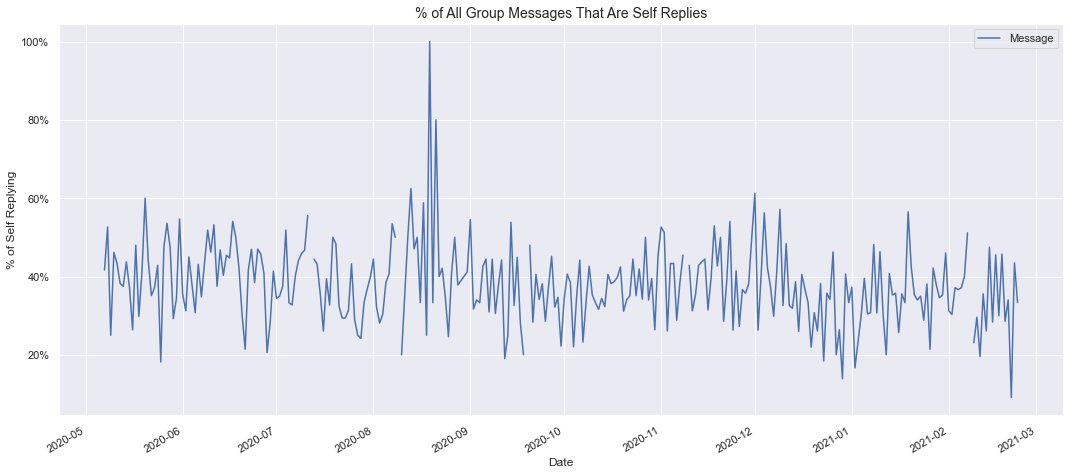

In [23]:
fig,ax = plt.subplots(figsize=(18,8))

(df[df.SelfReply][['Date', 'Message']]
 .groupby(['Date']).count() /
 df[['Date', 'Message']]
 .groupby(['Date']).count()).plot(ax=ax);

# tidy up the figure
ax.set_title('% of All Group Messages That Are Self Replies', fontdict={'fontsize': 14})
ax.set_ylabel('% of Self Replying')
ax.set_yticklabels(['{:,}'.format(int(x*100))+'%' for x in ax.get_yticks().tolist()]);

And now breaking down the count (not %) by author:

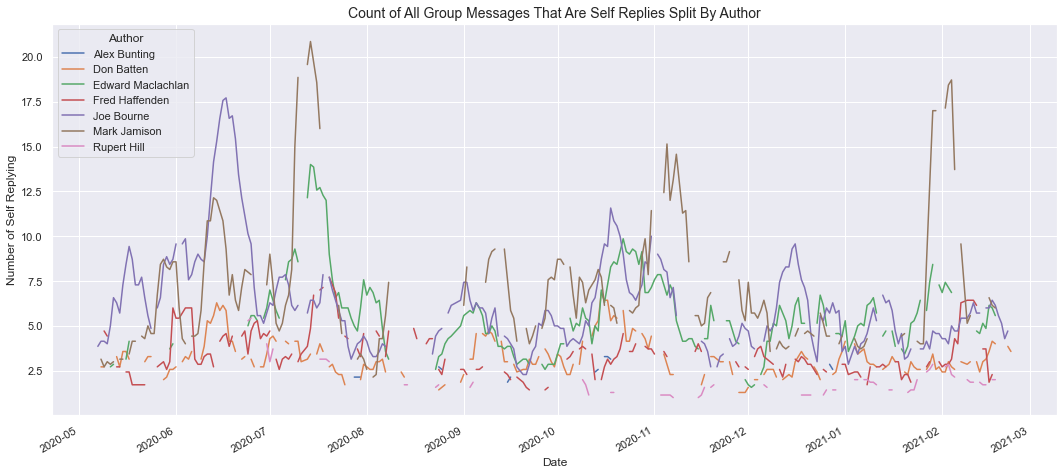

In [24]:
fig,ax = plt.subplots(figsize=(18,8))

pd.pivot_table((df[df.SelfReply][['Author', 'Date', 'Message']]
                .groupby(['Author', 'Date']).count().rolling(7).mean()),
               columns='Author',
               index='Date',
               values='Message').plot(ax=ax);

# tidy up the figure
ax.set_title('Count of All Group Messages That Are Self Replies Split By Author', fontdict={'fontsize': 14})
ax.set_ylabel('Number of Self Replying');

So no - everyone remains steadfast oscillating around their specific brand of rapid fire. __My recent peak likely me loving the opportunity to mansplain the GME gamma death spiral.__

### 2c. Is There a Correlation Between More-Rapid-Firey and Shorter Messages?

If people (me) choose to send a ton of messages, do we then send shorter messages?

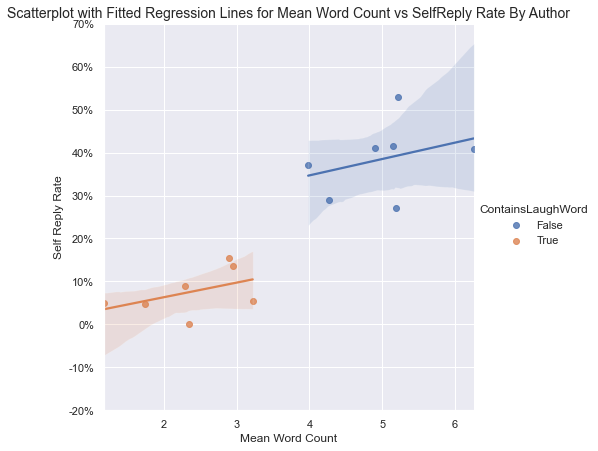

In [25]:
#fig,ax =plt.subplots()

sns.lmplot(data=df[['Author', 'ContainsLaughWord', 'WordCount', 'SelfReply']].groupby(['Author', 'ContainsLaughWord']).mean().reset_index(), 
           x='WordCount',
           y='SelfReply',
           hue='ContainsLaughWord',
           size=6
          );

plt.title('Scatterplot with Fitted Regression Lines for Mean Word Count vs SelfReply Rate By Author', fontdict={'fontsize': 14})
plt.xlabel('Mean Word Count');
plt.ylabel('Self Reply Rate');
plt.yticks(plt.yticks()[0], ['{:,}'.format(int(x*100))+'%' for x in plt.yticks()[0].tolist()]);

The above scatter / reg plot shows us the avg word count vs the self reply rate, with 12 points: {6 authors, laugh-word containing or not). So in general, __no__:
 - the _general_ positive slope indicates that more-self-replyie leads to slightly longer messages (i.e. me mainsplaining GME gamma holes)
 - LWCM tend to have lower word counts (makes sense as a lot of these are one word responses i.e. 'haha')
 - Not very statistically significant (shown by the fact a horizontal line - no correlation - could likely be wedged in those shaded 95% confidence bands)
 
So not all that interesting.

## 3. HAWT CONTENT

Sometimes we discuss what's for lunch, sometimes the relative merits of Yorkshire vs PG Tips (although none of us as qualified as [stock man](https://steepster.com/discuss/13826-pg-tips-vs-yorkshire-tea), but mostly it's a thread of HaWt CoNtEnT and the following response.

Let's have a look at what kind of stuff we share and if we bring different sources to the (metaphorical) table. We first need to do a bit of work to isolate messages containing content, where we define this as:
 - url-containing
 - image, video, voice note containing

In [26]:
# contains url content - url if so, 'None' if nay
# find http containing messages, listify message, select where http in word
def url_from_message(message):
    mess_list = message.split(' ')
    url_list = [x for x in mess_list if 'http' in x]
    url = 'None'
    if len(url_list) > 0:
        url = url_list[0]
    return url

In [27]:
# strip out url from messages that contain them
# make col for either viz or url content
df['ContainsUrl'] = df['Message'].apply(lambda x: url_from_message(x))
df['ContainsContent'] = (df['ContainsViz'] != 'None') |  (df['ContainsUrl'] != 'None')

# sort then add for if previous col was content
df = df.sort_values(['Group', 'DateTime'])
df['PrevMessContainsContent'] = df.groupby(['Group'])['ContainsContent'].shift()
df = df.dropna()

Now we'd like to group all these urls based on their source - this is a bit tricky given it's _so in vogue_ to have your own url (.ai the most pretentious I've seen) but we can build a function that handles most cases.

In [28]:
def url_helper(url):
    if url == 'None':
        return 'None'
    else:
        url_exhttp = url.replace('https://', '').replace('http://', '')
        if 'twitter' in url_exhttp:
            return 'twitter'
        url_after_www = url_exhttp[url_exhttp.find('.')+1:]
        url_pre_com = url_after_www[:url_after_www.find('.')]
        
        # can't think of a better way to do this
        if url_pre_com[:2] == 'be':
            url_source = 'youtube'
        elif url_pre_com[:3] == 'you':
            url_source = 'youtube'
        elif url_pre_com[:3] == 'com':
            url_source = url_exhttp[:url_exhttp.find('.')]
        elif url_pre_com[:2] in ['pt', 'nl', 'fm', 'me', 'st', 'ai']:
            url_source = url_exhttp[:url_exhttp.find('.')]
            if url_source == 'www':
                url_source = url_pre_com
        else:
            url_source = url_pre_com
            
        return url_source

In [29]:
# define url source  - will be 'None' if no url
df['UrlSource'] = df['ContainsUrl'].apply(lambda x: url_helper(x))
# get source of content across urls and image, vidz etc.
df['ContentSource'] = np.where(df['UrlSource'] != 'None', df['UrlSource'], df['ContainsViz'])

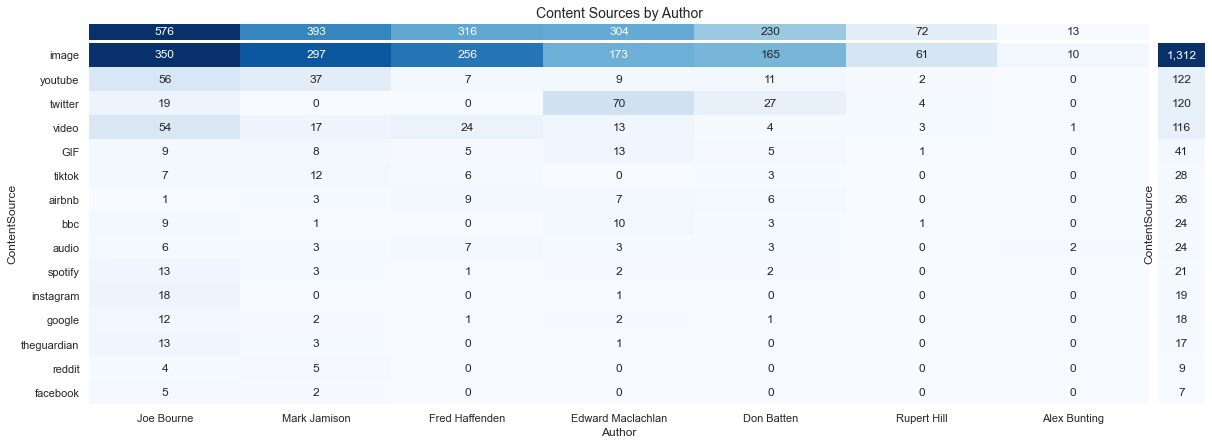

In [30]:
# amended/stripped from https://stackoverflow.com/questions/33379261/how-can-i-have-a-bar-next-to-python-seaborn-heatmap-which-shows-the-summation-of
# create heatmap with totals
fig = plt.figure(figsize=(20,7))
ax2 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=1)
ax1 = plt.subplot2grid((20,20), (1,0), colspan=19, rowspan=19)
ax3 = plt.subplot2grid((20,20), (1,19), colspan=1, rowspan=19)

# create grid with rows and cols sorted (condenses colour in top left)
df_content = pd.pivot_table(df[df.ContentSource != 'None'][['Author', 'ContentSource', 'Message']]
                       .groupby(['Author', 'ContentSource']).count(),
                       columns='Author',
                       index='ContentSource',
                       values='Message').fillna(0)
# order matrix and only show top 15 sources
df_content = df_content.loc[df_content.sum(axis=1).sort_values(ascending=False).index][df_content.sum().sort_values(ascending=False).index].head(15)

# plot the heatmap
sns.heatmap(df_content,
            ax=ax1,
            cmap='Blues',
            annot=True,
            cbar=False,
            fmt=',.0f');
# plot the row totals on the far right
sns.heatmap(pd.DataFrame(df_content.sum(axis=1)), ax=ax3,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
# plot the col totals on top with an accompanying title
sns.heatmap((pd.DataFrame(df_content.sum(axis=0))).transpose(), ax=ax2,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
ax2.set_title('Content Sources by Author', fontdict={'fontsize': 14});

Few interesting things here:
 - JB is a behemoth in the content sharing world, demonstrating colossal breadth and depth in his strive to keep us humurously informed
 - observational banter reigns supreme with 'image' and 'video' being heavily distributed
 - there are clear twitter users among us - Ed and Dom - in comparison to myself and Fred
 - I cannot reiterate enough just how much content JB shares

## 4. Response Times - What Does Our Response Behaviour Look Like?

Nothing so far has looked at the fact that all this data takes place _through_ time. Word counts, who we reply to, the sequence of all these messages - each message is in response (mostly) to another and messages are clustered at different times of day.

None of what we've looked at so far has taken this into account - so let's look at the intertemporal aspect now. As a quick prelim, let's have a look at when in the day we message - we can plot our message counts by hour in the day by author.

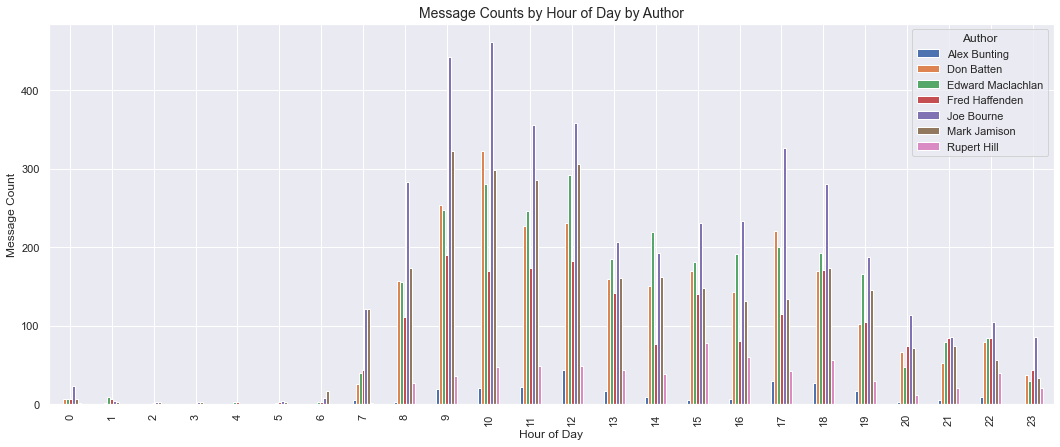

In [32]:
fig, ax = plt.subplots(figsize=(18,7))
pd.pivot_table(df[['Message', 'Hour', 'Author']].groupby(['Hour', 'Author']).count(), columns='Author', index='Hour', values='Message').plot(kind='bar', ax=ax);

plt.title('Message Counts by Hour of Day by Author', fontdict={'fontsize': 14})
plt.xlabel('Hour of Day');
plt.ylabel('Message Count');

So much like enthusiasm for Lockdown 1.0, we start strong then wither:
 - in these _unprecedented times_ we're not as active as we used to be in the wee hours
 - overall individual contributions carry through the hourly level - JB still rockin it most hours of the day
 - there's a post lunch lull - either because we're pacing it at work to get through stuff or both work and whatsapp are suffering from too much grub

In [33]:
# ensure correctly sorted
df = df.sort_values(['Group', 'DateTime'])

# add previous message DateTime for density analysis
df['PrevDateTime'] = df.groupby('Group')['DateTime'].shift()
# compute time delta between mess and prev mess
df['TimeSinceLastMess'] = df['DateTime'] - df['PrevDateTime']
# create numeric type for time since last message
df['TimeSinceLastMessSeconds'] = df['TimeSinceLastMess'].dt.total_seconds()

# record a col to check if the reply's are intra-day
df['PrevDate'] = df.groupby(['Group'])['Date'].shift()
df['PrevMessSameDay'] = df['Date'] == df['PrevDate']
# drop first message in each group as we don't have time delta info for it
df = df.dropna()

Finally let's make a note of the first message (per group) each day so we don't count it in 'reply time analysis'

In [34]:
df_first_mess_time = df[['Group', 'Date', 'Time']].groupby(['Group', 'Date']).first().reset_index()
df_first_mess_time = df_first_mess_time.rename(columns={'Time': 'FirstMessTime'})
df = pd.merge(left=df, right=df_first_mess_time, on=['Group', 'Date'])
df['IsFirstMess'] = df['Time'] == df['FirstMessTime']

### 4a. What Does Message Dispersion Look Like?

Let's have a look at various aspects of message dispersion. Before diving into variations in response time between different message types / author, let's just plot the series in general.

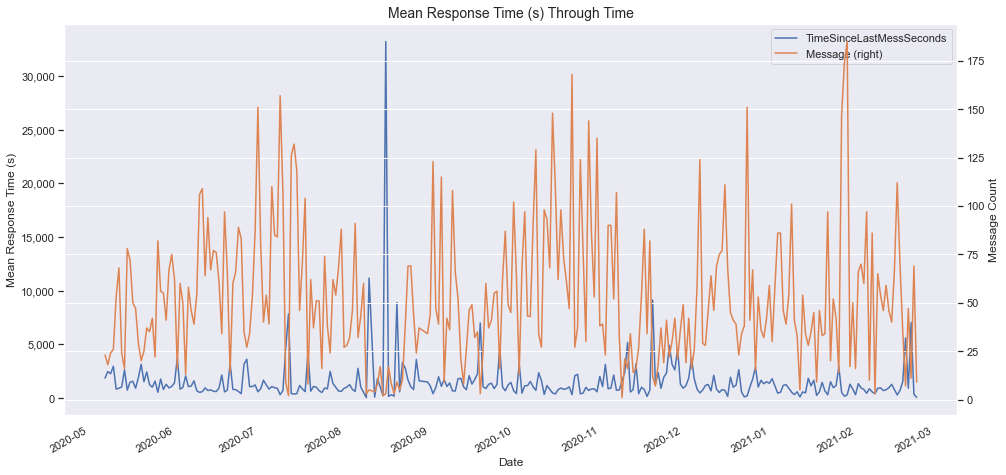

In [35]:
fig,ax = plt.subplots(figsize=(16,8))

# plot the response time avg through time
df[df.PrevMessSameDay][['Date', 'TimeSinceLastMessSeconds']].groupby('Date').mean().plot(ax=ax);
plt.ylabel('Mean Response Time (s)')
# plot the overall message volume through time
df[['Date', 'Message']].groupby('Date').count().plot(ax=ax, secondary_y=True);
plt.ylabel('Message Count')

# add labels
plt.title('Mean Response Time (s) Through Time', fontdict={'fontsize': 14})
plt.xlabel('Date')

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);

So we appear to have a few outliers - especially mid summer of 2020 and early Dec 2020, which we can see was caused by overall low message volume.

Let's remove those days with very low volume as they cloud the analysis by stripping out the bottom 10% - we're trying to look at reply times and not count the bookends of distinct intra-day threads.

In [36]:
quantile = 0.1
# generate message count per day
df_daily_mess_count = df[['Date', 'Message']].groupby('Date').count()
# get the 5% quantile - remove days with message counts below it
five_perc_qu = df_daily_mess_count.quantile(q=quantile).values[0]
print('Removing days with less than {} messages'.format(five_perc_qu))
low_mess_dates = df_daily_mess_count[df_daily_mess_count.Message < five_perc_qu].index.values

### REMOVING DATA
print('Removing {:,} messages from {:,}, by discarding bottom {:,.1%} of days'.format(len(df[df.Date.isin(low_mess_dates)]), len(df), quantile))
df = df[~df.Date.isin(low_mess_dates)]

Removing days with less than 13.8 messages
Removing 199 messages from 15,270, by discarding bottom 10.0% of days


Now it looks a bit better:

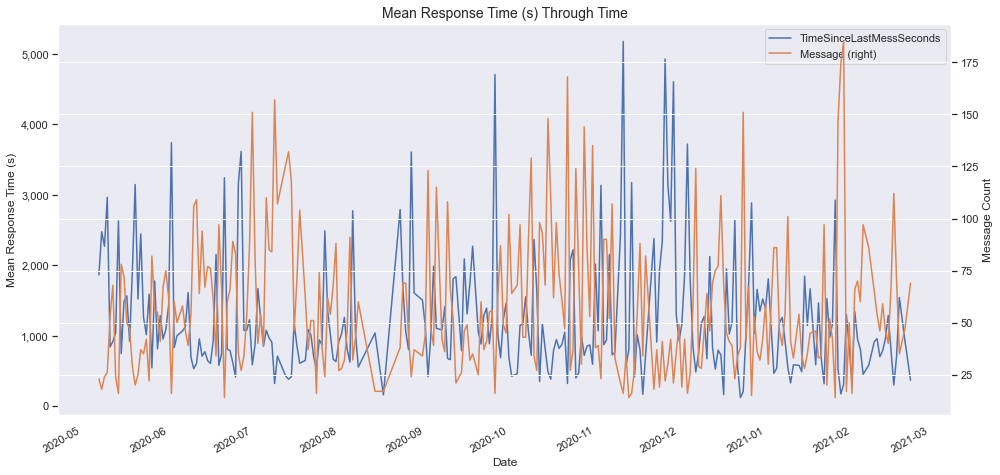

In [37]:
fig,ax = plt.subplots(figsize=(16,8))

# plot the response time avg through time
df[df.PrevMessSameDay][['Date', 'TimeSinceLastMessSeconds']].groupby('Date').mean().plot(ax=ax);
plt.ylabel('Mean Response Time (s)')
# plot the overall message volume through time
df[['Date', 'Message']].groupby('Date').count().plot(ax=ax, secondary_y=True);
plt.ylabel('Message Count')

# add labels
plt.title('Mean Response Time (s) Through Time', fontdict={'fontsize': 14})
plt.xlabel('Date')

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);

### 4b. 'Lead Balloons'

Now in and amongst __all that banter__, there are times that some stuff just doesn't stick. You laugh your head off upon first view, ping it in to the group and the tumbleweed rolls on by. Can we use what we've got to identify at least a sub-sample of these events?

Turns out we can. Let's define a tumbleweed inducing message as:
 - content: either a url, video, gif, sticker or image
 - unreplied: the following message comes at least 2hrs after

In [51]:
# identify them by responses
LEAD_BALLOON_TIME = 60*60*2
led_ball_response_idx = df[(df.TimeSinceLastMessSeconds > LEAD_BALLOON_TIME) & df.PrevMessContainsContent].index
# mark prev message as lead balloon
df['LeadBalloon'] = df.index.isin([x-1 for x in led_ball_response_idx])

So let's have a look at what the main content sources of unreplied content containing messages are:

In [93]:
# get lead balloon count by source for big content sources
lb_df = df[(df.LeadBalloon) & (df.ContentSource.isin(df_content.index))][['ContentSource', 'Message']].groupby('ContentSource').count()
# get all content sharing by source for big content sources
all_content_df = df[df.ContainsContent & df.ContentSource.isin(df_content.index)][['ContentSource', 'Message']].groupby('ContentSource').count()
(lb_df / all_content_df).sort_values('Message', ascending=False).dropna()

,Message
ContentSource,
facebook,0.285714
reddit,0.222222
twitter,0.152542
GIF,0.150000
youtube,0.135593
tiktok,0.115385
instagram,0.105263
video,0.105263
image,0.085537


So it looks like Facebook and Reddit by quite a margin:
 - maybe because they have less descriptive previews and so the time taken to see the content is 'riskier'
 - maybe because they have a higher 'barrier to entry' - need the respective apps rather than just a browser

Upon general inspection of the 'lead balloons', most are not lead balloons at all. It's just related to how easy it is to get the core message from the content and respond. As such, the recipe for a lead balloon is this:
 - send just after lunch when people generally message less: either through post-lunch lull or work catch up post break
 - send long articles or long videos e.g. **a 32 minute highlight reel of Lebron vs MJ is perfect**
 - send stuff that has a poor preview so clicking on the link is actually required to read the info (given most links are not actually clicked on)

### 4c. Speedy Repsonders

Finally, let's a look at how responsive each of us are on the group.

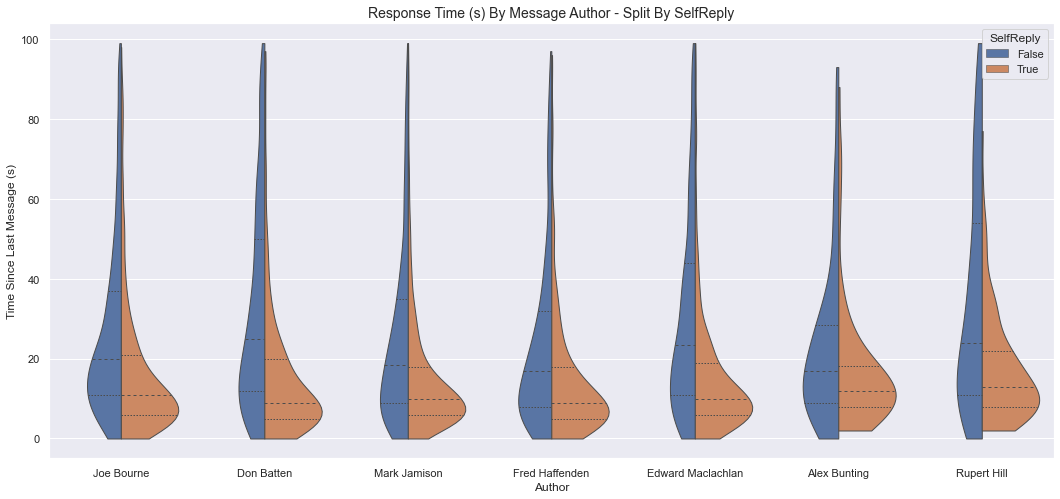

In [96]:
fig, ax = plt.subplots(figsize=(18,8))

sns.violinplot(data=df[df.PrevMessSameDay & (df.TimeSinceLastMessSeconds < 100)],
               x="Author", y="TimeSinceLastMessSeconds", hue="SelfReply", ax=ax,
               cut=0, split=True, inner="quart", linewidth=1);

ax.set_title('Response Time (s) By Message Author - Split By SelfReply', fontdict={'fontsize': 14})
ax.set_xlabel('Author')
ax.set_ylabel('Time Since Last Message (s)');

## 5. Concluding Remarks

So it seems across the board there are little nuggets of info that mean we have differing message styles be that message length, what media we share or how long ago the previous message was. Now, let's try and use that info to make a classifier that can correctly predict who is sending what message.

In [97]:
df.to_csv('./data/wa_df_2.csv', index=False)